# Facility Location

## Model Formulation

### Decision Variables

$select_{j} \in \{0, 1 \}$: This variable is equal to 1 if we build a facility at candidate location $j \in J$; and 0 otherwise.

### Objective Function:


\begin{equation}
\text{Min} \quad \sum_{i}\sum_{j} J_{ij} \cdot select_{i} \cdot select_{j} + \sum_{i \in I} h_{i} \cdot select_{i}
\tag{0}
\end{equation}

### Constraints:

\begin{equation}
\sum_{i \in ATMs} \sum_{j \in clients} d_{ij} = h_{i}
\tag{1}
\end{equation}

\begin{equation}
J_{ij} = - d_{ij}
\tag{2}
\end{equation}

\begin{equation}
\sum_{i} select_{i} = K
\tag{3}
\end{equation}

In [1]:
%pip install gurobipy


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 10.2/10.2 MB 3.7 MB/s eta 0:00:00


In [2]:
from itertools import product
from math import sqrt
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import numpy as np

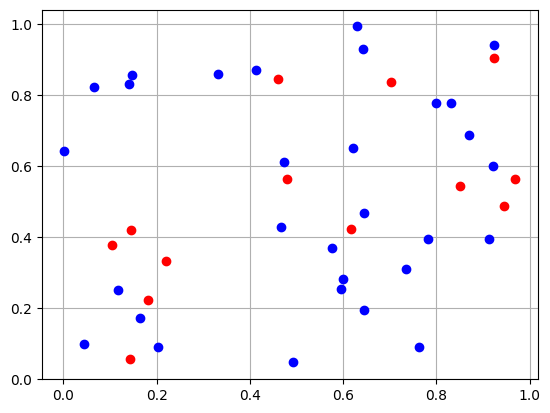

In [3]:
# Set random point for Custumers and facilities (ATMs) in the graph:
customers=[(np.random.rand(),np.random.rand()) for _ in range(30)]
facilities=[(np.random.rand(),np.random.rand()) for _ in range(13)]

for c in customers:
  plt.plot(c[0],c[1], 'bo')
for f in facilities:
  plt.plot(f[0],f[1], 'ro')
plt.grid(True)
plt.show()

In [4]:
# This function determines the Euclidean distance between a facility and customer sites / between a facility i and facility j.

def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)

# Compute key parameters of MIP model formulation

num_facilities = len(facilities)
num_customers = len(customers)
# Set the coordinates that link facility i to other facilities:
coordinates_ij=[(i,j) for i in range(num_facilities-1) for j in range(i+1,num_facilities)]


print(num_facilities, num_customers)
#print(facilities)
print(coordinates_ij)

13 30
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (8, 9), (8, 10), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12), (11, 12)]


In [5]:
# MIP  model formulation

m = gp.Model('facility_location')

# Inject variable into the model:
select = m.addVars(num_facilities, vtype=GRB.BINARY, name='Select')
h = m.addVars(num_facilities, vtype=GRB.CONTINUOUS, name='h')
J = m.addVars(coordinates_ij, vtype=GRB.CONTINUOUS, name='J')

mul= m.addVars(coordinates_ij, vtype=GRB.CONTINUOUS, name='mul')

# Define constantes
K=4
weight_J=1
weight_h=1

m.update()
# Inject constraints into the model:
for i in range(num_facilities):
  m.addConstr(weight_h*gp.quicksum(compute_distance(facilities[i],customers[j]) for j in range(num_customers)) == h[i], name=f'distFC_{i}')

for i in range(num_facilities-1):
  for j in range(i+1,num_facilities):
    m.addConstr(J[(i,j)] == weight_J*compute_distance(facilities[i],facilities[j]), name=f'J_{i}{j}')

m.addConstr(gp.quicksum(select[i] for i in range(num_facilities)) == K)

# Because the products of three variables is not supported by Gurobi in the objective function I will define a new variable called mul. See: https://support.gurobi.com/hc/en-us/community/posts/360056771292-Invalid-argument-to-QuadExpr-multiplication-Error-
m.addConstrs(mul[(i,j)]==(select[i]*select[j]) for j in range(i+1,num_facilities) for i in range(num_facilities-1))

# Inject the objective function
m.setObjective(gp.quicksum(-J[(i,j)]*mul[(i,j)] for j in range(i+1,num_facilities) for i in range(num_facilities-1)) + gp.quicksum(h[j]*select[j] for j in range(num_facilities-1)), GRB.MINIMIZE)

m.update()
m.optimize()
print()
print(f'runtime is {m.Runtime}s')

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 92 rows, 182 columns and 104 nonzeros
Model fingerprint: 0xbf3fc3b9
Model has 24 quadratic objective terms
Model has 12 quadratic constraints
Variable types: 169 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 91 rows and 157 columns
Presolve time: 0.00s
Presolved: 49 rows, 37 columns, 121 nonzeros
Variable types: 0 continuous, 37 integer (37 binary)
Found heuristic solution: objective 52.3309

In [6]:
# display optimal values of decision variables

for facility in select.keys():
    if (abs(select[facility].x) > 1e-6):
        print(f"\n Build an ATM at location {facility + 1}.")


 Build an ATM at location 7.

 Build an ATM at location 10.

 Build an ATM at location 11.

 Build an ATM at location 13.


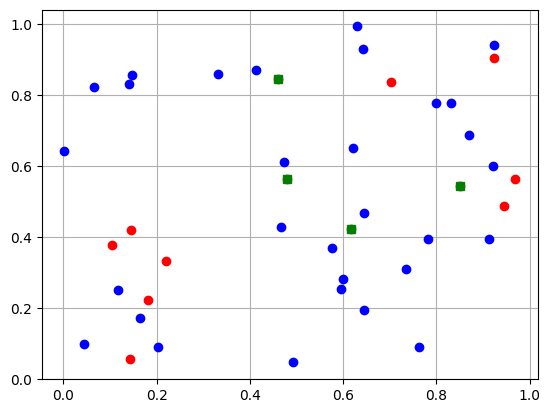

In [7]:
for c in customers:
  plt.plot(c[0],c[1], 'bo')

from itertools import compress
ss=[select[i].x for i in range(num_facilities)]
fil = [True, False, True, False]
rr=list(compress(facilities, ss))

for f in facilities:
  plt.plot(f[0],f[1], 'ro')

for f in rr:
  plt.plot(f[0],f[1], 'gs')

plt.grid(True)
plt.show()